In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
import scipy

In [3]:
low_b = 2
up_b = 5

In [57]:
x0 = np.linspace(0,up_b)
y0s = np.array([-x0 + b for b in np.linspace(low_b,up_b)])

In [70]:
pairs = pd.DataFrame(np.vstack([np.reshape(y0s,(2500,)),np.tile(x0,int(2500/len(x0)))]).T)
pairs = pairs[pairs[0] >0]

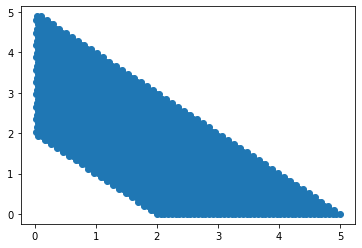

In [71]:
plt.scatter(pairs[0],pairs[1])

In [72]:
pairs_tr = pairs.apply(lambda row: (row[0]*(up_b-low_b)/(row[0]+row[1]) + low_b,row[0]+row[1]),axis=1)
pairs_tr = pd.DataFrame(list(pairs_tr))

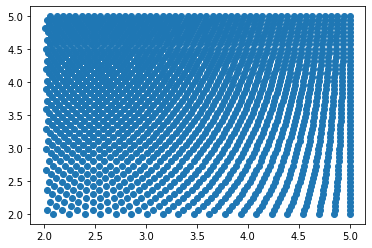

In [73]:
plt.scatter(pairs_tr[0],pairs_tr[1])

# 3d version?

generate coordinates with the rule

$3 \leq \sum x_i \leq 5$

In [3]:
n_points = 1000
points = []
l=3
u=5
while len(points) < n_points:
    candidate = [np.random.random()*5 for i in range(3)]
    if l <= sum(candidate) <= u:
        points.append(candidate)
    else:
        continue

In [4]:
points_tr =\
[
    (
        x[0]*(u-l)/(x[0]+x[1])+l,
        (x[0]+x[1])*(u-l)/(x[0]+x[1]+x[2]) + l,
        x[0]+x[1]+x[2]
    )
    for x in points
]

In [5]:
# yes, the constraints are satisfied
# This is necessary but is it sufficient?
all([all(l<np.array(p)) and all(np.array(p)<=u) for p in points_tr])

True

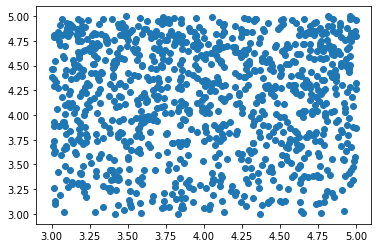

In [6]:
points_tr_df = pd.DataFrame(points_tr)
plt.scatter(x=points_tr_df[0],y=points_tr_df[2])

In [8]:
points_tr[1]

(3.568677277733593, 4.295538139885748, 4.898889738355717)

In [7]:
tr(points[1],l=l,u=u,dim=3)[0]

NameError: name 'tr' is not defined

In [263]:
points_tr_df[0]

0      3.186375
1      4.221508
2      4.243353
3      4.454883
4      3.042145
         ...   
995    3.183753
996    4.991500
997    3.262931
998    3.721570
999    4.338673
Name: 0, Length: 1000, dtype: float64

In [202]:
# does the inverse transformation work?
# it does, but it's quite numerically unstable
def inv_tr(point,l,u):
    dim = len(point)
    cur_index = dim-1
    sums = []
    sums.insert(0,point[cur_index])
    while cur_index > 0:
        last_sum = sums[0]
        next_sum = (last_sum*(point[cur_index-1]-l))/(u-l)
        sums.insert(0,next_sum)
        cur_index = cur_index -1
    x = [sums[i]-sums[i-1] for i in range(dim-1,0,-1)]
    x.reverse()
    x.append(sums[1])
    return np.array(x)

In [13]:
# maybe we can make it better by posing it as a linear system
# and hoping that the np solver does something smart
from scipy.optimize import root
def inv_tr_lin_solve(point,l,u):
    dim = len(point)
    coeff_matrix = np.eye(dim)
    # add bottom row of ones
    #coeff_matrix[dim-1,:] = np.ones(dim)
    # add coefficients to off-diagonal
    for i in range(0,dim-1):
        coeff_matrix[i,i+1] = (l-point[i])/(u-l)
    #print(coeff_matrix)
    b = np.zeros(dim)
    b[dim-1] = point[dim-1]
    #print(b)
    L = np.tril(np.ones((dim,dim)))
    x = scipy.linalg.solve(coeff_matrix@L,b)
    return x
    #def objective(x):
    #    return (coeff_matrix@L)@x-b
    #return root(objective,np.ones(dim))

In [10]:
points_un_tr = [inv_tr(point,l,u) for point in points_tr]

NameError: name 'inv_tr' is not defined

In [276]:
all([all(np.isclose(p1,p2)) for p1,p2 in zip(points_un_tr,points)])

False

In [277]:
inv_tr(points_tr[0],l,u)

array([2.09721029, 2.25310288, 2.31272804])

In [15]:
sol = inv_tr_lin_solve(points_tr[0],l,u)
print(sol)
sum(sol)

[0.30977091 3.27476642 0.17342987]


3.7579672024009643

In [16]:
points[0]

[0.30977090930185913, 3.2747664205098417, 0.17342987258926357]

In [17]:
sol-points[0]

array([-1.11022302e-16,  0.00000000e+00,  2.77555756e-17])

# Stress test: 705 dimensions

In [281]:
n_points = 1000
points = []
l=3
u=5
while len(points) < n_points:
    candidate = [np.random.random()*5 for i in range(705)]
    if l <= sum(candidate) <= u:
        points.append(candidate)
    else:
        continue

KeyboardInterrupt: 

In [349]:
# better way of generating random numbers?
n_points = 1000
points = []
l=10000
u=12000
while len(points) < n_points:
    target_sum = np.random.random()*(u-l) + l
    x = [np.random.random() for i in range(704)]
    x.insert(0,0)
    x.append(1)
    x.sort()
    points.append(np.diff(x)*target_sum)
    
points = np.float128(points)

In [350]:
all([l<sum(p)<u for p in points])

True

In [351]:
len(points[0])

705

In [39]:
#from multiprocess import Pool

ModuleNotFoundError: No module named 'multiprocess'

In [9]:
def tr(point,l=10000,u=12000,dim=705):
    point = np.float128(np.array(point))
    point_tr = [((np.sum(point[0:i])*(u-l))/np.sum(point[0:i+1])) + l for i in range(1,dim)]
    point_tr.append(np.sum(point))
    return np.array(point_tr)

In [353]:
points_tr = np.array([tr(p) for p in points])
len(points_tr[0])

705

In [128]:
points_tr[0]

numpy.float128

In [322]:
all([all(l<=p) and all(p <= u) for p in points_tr])

False

In [354]:
points_un_tr = [inv_tr_lin_solve(point,l,u) for point in points_tr]

KeyboardInterrupt: 

In [252]:
len(points_un_tr[0])

706

In [253]:
len(points[0])

706

In [254]:
sum(points_un_tr[0])

10382.091368369422

In [366]:
sol = inv_tr_lin_solve(points_tr[0],l,u)
print(sol[0:10])

[43.16119406  2.93483665 24.12495996  4.77946951 20.69740973 33.86794146
 12.00535482  0.37810627 23.3817131   7.36897264]


In [367]:
points[0][0:10]

array([43.16119406,  2.93483665, 24.12495996,  4.77946951, 20.69740973,
       33.86794146, 12.00535482,  0.37810627, 23.3817131 ,  7.36897264],
      dtype=float128)

In [364]:
(sol-points[0])*100/points[0][0:10]

ValueError: operands could not be broadcast together with shapes (705,) (10,) 

In [365]:
(sol- points[0])*100/points[0]

array([ 6.68378985e-12,  1.55855995e-12, -3.54903800e-12,  1.33799046e-11,
        3.69047843e-12, -7.25901180e-12, -1.49443347e-12, -4.84484952e-12,
        3.49471462e-12,  2.41058954e-12,  6.62468748e-13, -9.17310851e-14,
       -7.66954412e-14,  2.52007732e-12,  2.01788002e-12,  9.80799683e-14,
       -1.02758753e-12,  3.92650280e-13,  5.04651119e-13, -7.12193786e-13,
       -1.12332346e-12, -4.21925073e-13, -2.17964937e-12, -1.22742299e-12,
        5.02890156e-13,  8.72722063e-13,  5.54829365e-13, -1.62473588e-13,
        1.44009583e-12,  2.99524495e-13,  1.87852774e-13,  3.22939174e-13,
        1.27319872e-12, -7.66187003e-13,  4.78713660e-13, -3.49391513e-13,
       -2.10284552e-13, -7.27962695e-13, -1.71325152e-13,  7.09082265e-13,
       -5.13200175e-13, -8.51570635e-14, -1.63327518e-12, -5.92171132e-14,
        1.57687887e-13,  5.07152812e-13, -9.04370595e-13, -1.81302808e-13,
       -1.33240815e-12, -6.95581310e-13,  1.39075683e-13,  6.64955391e-13,
        7.70144751e-12,  

# Equality constraint
It looks the original inequality constraint is too tricky. Let's try formulating the problem using an equality constraint instead.

## 4 dimensions: basic test

In [2]:
def generate_number_summing_to(sum_target,dim,n_points):
    # better way of generating random numbers?
    points = []
    while len(points) < n_points:
        x = [np.random.random() for i in range(dim)]
        x.insert(0,0)
        x.append(1)
        x.sort()
        points.append(np.diff(x)*sum_target)
    points = np.float128(points)
    return points

In [3]:
def generate_points_between(l,u,dim,n_points):
    points = []
    while len(points) < n_points:
        x = [np.random.random()*(u-l) + l for i in range(dim)]
        points.append(x)
    points = np.float128(points)
    return points

In [4]:
points = generate_number_summing_to(160000,4,100)

NameError: name 'np' is not defined

In [27]:
points = generate_points_between(10000,12000,4,100)

In [29]:
# maybe we can make it better by posing it as a linear system
# and hoping that the np solver does something smart
from scipy.optimize import root
def inv_tr_lin_solve_eq(point,l,u,c):
    dim = len(point)
    coeff_matrix = np.eye(dim)
    # add bottom row of ones
    #coeff_matrix[dim-1,:] = np.ones(dim)
    # add coefficients to off-diagonal
    for i in range(0,dim-1):
        coeff_matrix[i,i+1] = (l-point[i])/(u-l)
    #print(coeff_matrix)
    b = np.zeros(dim)
    b[dim-1] = c
    #print(b)
    L = np.tril(np.ones((dim,dim)))
    x = scipy.linalg.solve(coeff_matrix@L,b)
    return x
    #def objective(x):
    #    return (coeff_matrix@L)@x-b
    #return root(objective,np.ones(dim))

In [33]:
inv_tr_lin_solve_eq(points[0],l=10000,u=12000,c=5)

array([1.03747451, 0.22800297, 1.18538557, 2.54913694])

# new constraint

In [30]:
v_0 = np.array([0.9,0.91,0.92,0.93])
v_delta = np.random.random(4)
P = np.array([10,20,30,40])
# transform it
v_delta_prime = v_delta*P
v_0_prime = v_0*P
v_delta_tr = np.array([np.sum(v_delta_prime[0:k])/np.sum(v_delta_prime[0:k+1])
         for k in range(1,4)])
v_0_tr = np.array([np.sum(v_0_prime[0:k])/np.sum(v_0_prime[0:k+1])
         for k in range(1,4)])

In [31]:
print(v_delta_tr)
print(v_0_tr)

[0.23371778 0.4610863  0.67155012]
[0.33088235 0.49635036 0.59565217]


In [20]:
v_delta

array([0.41721945, 0.86956543, 0.77410788, 0.73430266])